In [2]:
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from numpy.random import shuffle
import random
np.set_printoptions(threshold=np.inf)

batch_size = 32  # Batch size for training.
epochs = 150  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 26000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'many_to_one_dataset.txt'
print(epochs)

Using TensorFlow backend.


150


In [14]:
data_path = 'dataset(only_bigram).txt'
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
    
file = open('dataset(only_bigram_test).txt','w',encoding="utf-8")    
for line in lines:
    data=line.split()
    #print(len(data))
    if(len(data)==3):
        continue
    input_text, target_text = line.split('\t')
    data=input_text.split(' ')
    line=input_text+'\t'+data[0]+' '+target_text+' '+data[2]+'\n'
    file.write(line)
    
file.close() 

In [15]:
# Vectorize the data.
data_path = 'dataset(only_bigram_test).txt'
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
    print(len(lines))
    print(lines[0])
    random.shuffle(lines)
    print(lines[0])
    
num_samples=137000    
for line in lines[: min(num_samples, len(lines) - 1)]:
    print(line)
    input_text, target_text = line.split('\t')
    # We use tab('\t') as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

76844
চূড়ান্ত পরিণতিতে সৃষ্টি	চূড়ান্ত পরিণতিতে সৃষ্টি
ওই লক্ষ্য পূরণ	ওই লক্ষ্য পূরণ
ওই লক্ষ্য পূরণ	ওই লক্ষ্য পূরণ
হয়তো স্পিনেই কুপোকাত	হয়তো স্পিনেই কুপোকাত
তাদের সঙ্গে যোগ	তাদের সঙ্গে যোগ
ডিজিটাল প্রযুক্তি সম্পর্কে	ডিজিটাল প্রযুক্তি সম্পর্কে
সহায়ক হবে। ফলে	সহায়ক হবে। ফলে
পঠিত গল্পটির উপজীব্য	পঠিত গল্পটির উপজীব্য
পাশে অবস্থিত এ	পাশে অবস্থিত এ
না। ওই যে	না। ওই যে
উল্যার কাছে জমা	উল্যার কাছে জমা
মৃত্যুর ঘটনাও ঘটেছে	মৃত্যুর ঘটনাও ঘটেছে
মধ্যে শ্রমিকের কর্মপরিবেশ	মধ্যে শ্রমিকের কর্মপরিবেশ
শোয়ার উপায় নেই।	শোয়ার উপায় নেই।
বছর প্রচুর বৃষ্টি	বছর প্রচুর বৃষ্টি
আরেক নতুন ধারা,	আরেক নতুন ধারা,
শুকাই। শ্বেতমুণ্ড ছায়া	শুকাই। শ্বেতমুণ্ড ছায়া
হলে হয়... ২.	হলে হয়... ২.
দিক আমাদের মতো	দিক আমাদের মতো
দেয়নি; তাতে কী,	দেয়নি; তাতে কী,
নিজস্ব গাড়ি ছিল	নিজস্ব গাড়ি ছিল
মত চলছে। দলের	মত চলছে। দলের
আয়োজিত এই ক্যাম্পে	আয়োজিত এই ক্যাম্পে
ফেরান নাসির হোসেন।	ফেরান নাসির হোসেন।
ভাঙবে, সেটাই আমাদের	ভাঙবে, সেটাই আমাদের
চাইলে সহকারী রিটার্নিং	চাইলে সহকারী রিটার্নিং
গাইবে ব্যান্ডটি। এ	গাইবে ব্যান্ডটি। এ
কাশ্মী

নেতা–কর্মীদের বিরুদ্ধে বেশুমার	নেতা–কর্মীদের বিরুদ্ধে বেশুমার
দাবি করেন, নেতা-কর্মীরা	দাবি করেন, নেতা-কর্মীরা
দিয়ে নৌযান চলাচলের	দিয়ে নৌযান চলাচলের
নির্বাচনের তারিখ ঘোষণা	নির্বাচনের তারিখ ঘোষণা
শ্রীলঙ্কা ও ভারতের	শ্রীলঙ্কা ও ভারতের
জীবনধর্ম ও কাব্যমূল্য	জীবনধর্ম ও কাব্যমূল্য
রোপিত হবে ধান	রোপিত হবে ধান
বিবিএ অনুষদের দ্বিতীয়	বিবিএ অনুষদের দ্বিতীয়
করা হয়েছে এটা	করা হয়েছে এটা
গ. ধান। #	গ. ধান। #
হাতে এসে পৌঁছায়নি।	হাতে এসে পৌঁছায়নি।
কোনো জবাব পাওয়া	কোনো জবাব পাওয়া
সভা করার জন্য	সভা করার জন্য
জিডি করে আগ্নেয়াস্ত্র	জিডি করে আগ্নেয়াস্ত্র
জানে বলে খ.	জানে বলে খ.
বিলুপ্ত হয়নি, সেগুলো	বিলুপ্ত হয়নি, সেগুলো
-পরাজয় জীবন -মরণ	-পরাজয় জীবন -মরণ
প্রবল পর্দা ও	প্রবল পর্দা ও
ক্ষীণ ধারায় আঁকাবাঁকা	ক্ষীণ ধারায় আঁকাবাঁকা
তার জন্য অমরত্বের	তার জন্য অমরত্বের
হিজল বা শেওড়াগাছে	হিজল বা শেওড়াগাছে
মধ্যে চাঁপাইনবাবগঞ্জে গ্রেপ্তার	মধ্যে চাঁপাইনবাবগঞ্জে গ্রেপ্তার
বছরে ঘসিয়াখালি খালের	বছরে ঘসিয়াখালি খালের
হয়ে যায়। পরে	হয়ে যায়। পরে
ও সাংসদ। কয়লা	ও সাংসদ। কয়লা
এসব তাই অন্তর্ভুক্ত	এসব তাই অন

হব ভিন্ন কেউ?	হব ভিন্ন কেউ?
ইরানের মধ্যকার কোনো	ইরানের মধ্যকার কোনো
থেকে চলছে এই	থেকে চলছে এই
তিন অংশ জোড়া	তিন অংশ জোড়া
us yesterday. You	us yesterday. You
দিতে পারে। যেমন	দিতে পারে। যেমন
নয় যে আমি	নয় যে আমি
বয়সেই তিনি বড়	বয়সেই তিনি বড়
কাছে, লুকিয়ে লুকিয়ে’।	কাছে, লুকিয়ে লুকিয়ে’।
পারলে তিন-চারজন থাকত	পারলে তিন-চারজন থাকত
পরিমাণ দাঁড়ায় ৩২৮	পরিমাণ দাঁড়ায় ৩২৮
ক্ষয়ে যাই দেবী,	ক্ষয়ে যাই দেবী,
সিটি করপোরেশনে মেয়র	সিটি করপোরেশনে মেয়র
করেছি। নতুন অ্যালবামের	করেছি। নতুন অ্যালবামের
ইসলামসহ তাঁদের কারও	ইসলামসহ তাঁদের কারও
ককটেল, কে পুড়ে	ককটেল, কে পুড়ে
শুরু করে, তাহলে	শুরু করে, তাহলে
চাপটা সরিয়ে নিলেন	চাপটা সরিয়ে নিলেন
নানা ভূখণ্ডের সংস্কৃতিও	নানা ভূখণ্ডের সংস্কৃতিও
বিশ্ব ঐতিহ্য এলাকা	বিশ্ব ঐতিহ্য এলাকা
ফার্গুসন পুলিশ বিভাগের	ফার্গুসন পুলিশ বিভাগের
শিবিরগুলোতে কাজ করছে।	শিবিরগুলোতে কাজ করছে।
ভাব প্রকাশের স্বায়ত্তশাসনের	ভাব প্রকাশের স্বায়ত্তশাসনের
দিকে অগ্রসর হচ্ছি।’	দিকে অগ্রসর হচ্ছি।’
ডিগ্রি কলেজ থেকে	ডিগ্রি কলেজ থেকে
সরকার-সমর্থকেরা নিজেরাই নিজেদের	সরকার-সমর্থকেরা নিজেরাই নিজেদে

কাটাতে হচ্ছে। বই	কাটাতে হচ্ছে। বই
বুলগাকভ তাঁর ক্লাসিক্যাল	বুলগাকভ তাঁর ক্লাসিক্যাল
যৌবনে পর্দাপণের সময়কে	যৌবনে পর্দাপণের সময়কে
বন্ধে প্রয়োজনীয় ব্যবস্থা	বন্ধে প্রয়োজনীয় ব্যবস্থা
মামুদপুর মহল্লার মো.	মামুদপুর মহল্লার মো.
কবিতা নিয়ে, প্রচ্ছদশিল্প	কবিতা নিয়ে, প্রচ্ছদশিল্প
আহরণ এবং তা	আহরণ এবং তা
বিজয়ীদের পরামর্শ নিয়ে	বিজয়ীদের পরামর্শ নিয়ে
নিই, তাহলেও আপনাদের	নিই, তাহলেও আপনাদের
বা সময় সম্পর্কে	বা সময় সম্পর্কে
সভাপতি ও ফারুক	সভাপতি ও ফারুক
বিশেষ করে সুন্দরবন	বিশেষ করে সুন্দরবন
প্রতিষ্ঠিত করতে পারেন।	প্রতিষ্ঠিত করতে পারেন।
কোন ভাব প্রকাশ	কোন ভাব প্রকাশ
এ মান্নান, সুনামগঞ্জ	এ মান্নান, সুনামগঞ্জ
সামনে এটাই তুলে	সামনে এটাই তুলে
উদ্বোধনের সময় সেতুটির	উদ্বোধনের সময় সেতুটির
পরম আশ্রয়স্থল হয়ে	পরম আশ্রয়স্থল হয়ে
অন্যকে মিষ্টিমুখ করান।	অন্যকে মিষ্টিমুখ করান।
সম্ভাবনার দুয়ার খুলে	সম্ভাবনার দুয়ার খুলে
বলেছেন, ‘ইসলামি রাষ্ট্রের	বলেছেন, ‘ইসলামি রাষ্ট্রের
ইউপির চেয়ারম্যান শহীদ	ইউপির চেয়ারম্যান শহীদ
স্টিয়ারিং কমিটির সিদ্ধান্তে।	স্টিয়ারিং কমিটির সিদ্ধান্তে।
হোমল্যান্ড, বিগ ব্যাং	হোমল্যান্ড, বিগ 

এর মধ্যে পাঁচটি	এর মধ্যে পাঁচটি
হয়ে বিয়ের পিঁড়িতে	হয়ে বিয়ের পিঁড়িতে
উপদেষ্টাও। তবে বিএনপির	উপদেষ্টাও। তবে বিএনপির
তবে এর দুই	তবে এর দুই
দিনাজপুর ডিবি পুলিশের	দিনাজপুর ডিবি পুলিশের
আহমেদ মজুমদার মেয়র	আহমেদ মজুমদার মেয়র
মাইকেল ব্রাউন হত্যাকাণ্ডের	মাইকেল ব্রাউন হত্যাকাণ্ডের
হাতে লাঞ্ছিত হওয়া	হাতে লাঞ্ছিত হওয়া
বেগম তাঁর প্রাথমিক	বেগম তাঁর প্রাথমিক
কিছুটা কমেছিল। কিন্তু	কিছুটা কমেছিল। কিন্তু
কল্যাণ ও আর্তমানবতার	কল্যাণ ও আর্তমানবতার
রাজধানীর এক অভিজাত	রাজধানীর এক অভিজাত
বলেন। এ ছাড়া	বলেন। এ ছাড়া
কেমব্রিজ প্রকাশিত (১৯৯৬)	কেমব্রিজ প্রকাশিত (১৯৯৬)
পর গতকাল সকাল	পর গতকাল সকাল
প্রশ্ন শুনে হা	প্রশ্ন শুনে হা
মাসে প্রকল্পের কাজ	মাসে প্রকল্পের কাজ
অর্থায়নের অক্ষমতা প্রকট।	অর্থায়নের অক্ষমতা প্রকট।
হচ্ছে, সেটা তিনি	হচ্ছে, সেটা তিনি
পণ্য আমদানি করলে	পণ্য আমদানি করলে
নৈতিক অবস্থানটি দেখভাল	নৈতিক অবস্থানটি দেখভাল
অডিয়েন্স অ্যাওয়ার্ড। পুরুষেরা	অডিয়েন্স অ্যাওয়ার্ড। পুরুষেরা
পাকিস্তান ও বাংলাদেশের	পাকিস্তান ও বাংলাদেশের
নিজ রূপের বাহার	নিজ রূপের বাহার
একটা পড়ে আছে।	একটা পড়ে আছে।
জানেন না যে,	জানেন ন

বড়ি দিয়ে ঘুম	বড়ি দিয়ে ঘুম
হবে বলে হুঁশিয়ারি	হবে বলে হুঁশিয়ারি
হুমকি দেওয়া দেশের	হুমকি দেওয়া দেশের
ও ইমানের বলে	ও ইমানের বলে
কর্মকাণ্ড করছে, সেগুলো	কর্মকাণ্ড করছে, সেগুলো
দলটি গত বছরের	দলটি গত বছরের
বিভাগীয় বন কর্মকর্তার	বিভাগীয় বন কর্মকর্তার
করেন। ছমিউদ্দিনের অভিযোগের	করেন। ছমিউদ্দিনের অভিযোগের
সাজে ফের রুপালি	সাজে ফের রুপালি
বর্তমান যুগ যোগাযোগের	বর্তমান যুগ যোগাযোগের
সূত্র নিশ্চিত করেছে।	সূত্র নিশ্চিত করেছে।
অনুযায়ী, গুলাম ছবির	অনুযায়ী, গুলাম ছবির
লক্ষণ বা উপসর্গে	লক্ষণ বা উপসর্গে
তাঁকে দেন আন্তরিক	তাঁকে দেন আন্তরিক
লেখার সময় বাংলাদেশের	লেখার সময় বাংলাদেশের
কর্মকর্তা (ওসি) নাজিমুদ্দিন	কর্মকর্তা (ওসি) নাজিমুদ্দিন
সবকিছুরই মীমাংসা করে	সবকিছুরই মীমাংসা করে
সৃজনশীলতায় রূপান্তরিত হয়	সৃজনশীলতায় রূপান্তরিত হয়
পাকিস্তানের সামরিক সরকারকে	পাকিস্তানের সামরিক সরকারকে
আমার পূর্ব বাংলা	আমার পূর্ব বাংলা
দেওয়া ৩. ‘আঠারো	দেওয়া ৩. ‘আঠারো
থাকলেও সে সুযোগ	থাকলেও সে সুযোগ
রুম ভাগাভাগি করতে	রুম ভাগাভাগি করতে
হাসপাতালের কয়েকটি ওয়ার্ডে	হাসপাতালের কয়েকটি ওয়ার্ডে
রপ্তানি প্রবৃদ্ধিতে অগ্র

আহমেদ। লেখক যখন	আহমেদ। লেখক যখন
পরিচিত। এখন আপিল	পরিচিত। এখন আপিল
থেকে কাঁথাটা টেনে	থেকে কাঁথাটা টেনে
রুম থেকে। ওই	রুম থেকে। ওই
তাঁর শরীরে বাসা	তাঁর শরীরে বাসা
করে আমার শরীর;	করে আমার শরীর;
ঘুরছে, কারখানার চাকা	ঘুরছে, কারখানার চাকা
আবহ সংগীতে নীলময়ূরী,	আবহ সংগীতে নীলময়ূরী,
বেশি হুমকির কারণ	বেশি হুমকির কারণ
হয়েছে। কার্যাদেশ দিলে	হয়েছে। কার্যাদেশ দিলে
তালিকাভুক্ত নয়—এমন প্রতিষ্ঠানগুলোর	তালিকাভুক্ত নয়—এমন প্রতিষ্ঠানগুলোর
face them with	face them with
পরে বাংলাদেশের তৈরি	পরে বাংলাদেশের তৈরি
হবে, এক পক্ষ	হবে, এক পক্ষ
করে। এ কক্ষে	করে। এ কক্ষে
খ. তৈলবীজ গ.	খ. তৈলবীজ গ.
এবং তৃতীয় প্রজন্মের	এবং তৃতীয় প্রজন্মের
খাল ভরাট করা	খাল ভরাট করা
করেছি। ৩ নম্বর	করেছি। ৩ নম্বর
wards. Parents of	wards. Parents of
সংস্কারের আবেদন জানিয়েছে।	সংস্কারের আবেদন জানিয়েছে।
তাদের মধ্যে কমে	তাদের মধ্যে কমে
তাই পরিবেশবাদীদের কেউ	তাই পরিবেশবাদীদের কেউ
ডাকাবুকো বোলারকে পিটিয়ে	ডাকাবুকো বোলারকে পিটিয়ে
নেতা-কর্মীকে জিজ্ঞাসাবাদের নামে	নেতা-কর্মীকে জিজ্ঞাসাবাদের নামে
তখন। এর পরের	তখন। এর পরের
যাওয়ার পর তাঁদের	য

ফাহাদের গ্রেপ্তারের খবর	ফাহাদের গ্রেপ্তারের খবর
শব্দ যোগকারী প্রথম	শব্দ যোগকারী প্রথম
প্রতিদ্বন্দ্বিতাও। দুজনই বাঁহাতি	প্রতিদ্বন্দ্বিতাও। দুজনই বাঁহাতি
বিতরণ করা হয়।	বিতরণ করা হয়।
প্রাথমিক পরীক্ষা-নিরীক্ষা চালিয়ে	প্রাথমিক পরীক্ষা-নিরীক্ষা চালিয়ে
এক খ. দুই	এক খ. দুই
কালিদাসের কোন বিখ্যাত	কালিদাসের কোন বিখ্যাত
বিশ্ববাসীকে। গুগলের মাধ্যমে	বিশ্ববাসীকে। গুগলের মাধ্যমে
আসা জঙ্গিদের সঙ্গে	আসা জঙ্গিদের সঙ্গে
জাকিউর রহমান ভূঁইয়া।	জাকিউর রহমান ভূঁইয়া।
যারা আইনব্যবস্থার সঙ্গে	যারা আইনব্যবস্থার সঙ্গে
পড়তেই হবে। কায়দাকানুনও	পড়তেই হবে। কায়দাকানুনও
delight. When papa	delight. When papa
এড়ানোর সুযোগ নেই।	এড়ানোর সুযোগ নেই।
উপজেলার সাধনপুর ইউনিয়ন	উপজেলার সাধনপুর ইউনিয়ন
সর্বোচ্চ রান স্কোরারের	সর্বোচ্চ রান স্কোরারের
জন তাঁদের প্রাপ্য	জন তাঁদের প্রাপ্য
বিভিন্ন ব্যক্তি ও	বিভিন্ন ব্যক্তি ও
ইনস্টিটিউট অব লেবার	ইনস্টিটিউট অব লেবার
খান: সাংবাদিক৷ mrkhanbd@gmail.com	খান: সাংবাদিক৷ mrkhanbd@gmail.com
সংগীত ও নৃত্যকলা	সংগীত ও নৃত্যকলা
জনপ্রিয় করে তুলতে	জনপ্রিয় করে তুলতে
বেকসুর খালাস দেন।	বেকসুর খাল

দলের জ্যেষ্ঠ এক	দলের জ্যেষ্ঠ এক
থাকা বেঞ্চ, চেয়ার-টেবিল,	থাকা বেঞ্চ, চেয়ার-টেবিল,
সহজ শর্তে ঋণ	সহজ শর্তে ঋণ
কর্তব্যরত কর্মকর্তা এএসআই	কর্তব্যরত কর্মকর্তা এএসআই
(ইন্ডিয়া অফিস লাইব্রেরি)	(ইন্ডিয়া অফিস লাইব্রেরি)
কৃষিসচিব আনোয়ার ফারুক	কৃষিসচিব আনোয়ার ফারুক
টন ২৮। বাংলাদেশের	টন ২৮। বাংলাদেশের
নিয়ে প্রায়ই বের	নিয়ে প্রায়ই বের
নকশা বাতিলের কথা	নকশা বাতিলের কথা
তবে তাঁকে হয়তো	তবে তাঁকে হয়তো
পেয়ে উদ্ধার করা	পেয়ে উদ্ধার করা
চেয়ারপারসন ‘রাজনৈতিক কোমায়’	চেয়ারপারসন ‘রাজনৈতিক কোমায়’
সূত্রে জানা গেছে,	সূত্রে জানা গেছে,
ব্যবহার: # By-এর	ব্যবহার: # By-এর
দেখি আমার এ	দেখি আমার এ
বিভিন্ন প্রাকৃতিক দুর্যোগে	বিভিন্ন প্রাকৃতিক দুর্যোগে
সহায়তা করবে। তবে	সহায়তা করবে। তবে
বলে আপনার মনে	বলে আপনার মনে
এফবিআই চরিত্রে দেখা	এফবিআই চরিত্রে দেখা
অ–আপসযোগ্য ও অজামিনযোগ্য	অ–আপসযোগ্য ও অজামিনযোগ্য
লেখকের চলে যাওয়ার	লেখকের চলে যাওয়ার
নৈতিক কারণে এবং	নৈতিক কারণে এবং
him than the	him than the
দেবী, হাহ্ সেটাই	দেবী, হাহ্ সেটাই
জন্য ১০ মেগাহার্টজ	জন্য ১০ মেগাহার্টজ
শেষ দিকে ফারহান	শেষ দিকে ফারহান
আমি সিডনিতে 

বার্ষিক পুরস্কার বিতরণী	বার্ষিক পুরস্কার বিতরণী
কারণ তাদের কেউ	কারণ তাদের কেউ
করার শক্তি সঞ্চয়ের	করার শক্তি সঞ্চয়ের
মোহাম্মদপুর থানা এলাকায়	মোহাম্মদপুর থানা এলাকায়
ওই কার্যালয়ের নির্বাহী	ওই কার্যালয়ের নির্বাহী
ডিবির কর্মকর্তারা বিষয়টি	ডিবির কর্মকর্তারা বিষয়টি
ডিজাইন অ্যাওয়ার্ড অনুষ্ঠানে	ডিজাইন অ্যাওয়ার্ড অনুষ্ঠানে
শতাংশের বাড়িতে পালন	শতাংশের বাড়িতে পালন
মুক্তি দাও, রেখে	মুক্তি দাও, রেখে
practical experience. It	practical experience. It
ক্যামেরার সামনে বলতে	ক্যামেরার সামনে বলতে
জন্য মাঝেমধ্যে শিক্ষকদের	জন্য মাঝেমধ্যে শিক্ষকদের
২৯ মার্চ। প্রার্থিতা	২৯ মার্চ। প্রার্থিতা
বিষয়ে কোনো তথ্য-প্রমাণ	বিষয়ে কোনো তথ্য-প্রমাণ
এসব শহর থেকে	এসব শহর থেকে
 আন্তর্জাতিক নাট্যোৎসব	 আন্তর্জাতিক নাট্যোৎসব
পাশে অস্ত্র দুটি	পাশে অস্ত্র দুটি
পথে হাঁটবে না	পথে হাঁটবে না
বলেই মনে করছেন	বলেই মনে করছেন
ডিসেম্বর গ. ২৩	ডিসেম্বর গ. ২৩
সেন্ট লুইসের ফার্গুসন	সেন্ট লুইসের ফার্গুসন
সূত্রে জানা গেছে,	সূত্রে জানা গেছে,
কোনো সম্পর্ক বা	কোনো সম্পর্ক বা
লাফ দিয়ে উঠে	লাফ দিয়ে উঠে
হতো। এরপর ওই	হতো। এরপর ওই
of the

মাটি কাটার পর	মাটি কাটার পর
অক্ষত অবস্থায় ফিরিয়ে	অক্ষত অবস্থায় ফিরিয়ে
ফেব্রুয়ারির রক্তাক্ত অধ্যায়।	ফেব্রুয়ারির রক্তাক্ত অধ্যায়।
‘শিক্ষক পুল’ হিসেবে	‘শিক্ষক পুল’ হিসেবে
the end of	the end of
মন্তব্য করতে চাননি।	মন্তব্য করতে চাননি।
হাজারের বেশি মানুষ	হাজারের বেশি মানুষ
এনামুল হক জানান,	এনামুল হক জানান,
স্বাভাবিক মৃত্যুর সুযোগ	স্বাভাবিক মৃত্যুর সুযোগ
২ ফেব্রুয়ারি বরিশাল	২ ফেব্রুয়ারি বরিশাল
‘সিন্ডারেলা’। ওয়াল্ট ডিজনি	‘সিন্ডারেলা’। ওয়াল্ট ডিজনি
হয় মাটির কন্দরে	হয় মাটির কন্দরে
দুরবস্থার কারণে ভোগান্তি	দুরবস্থার কারণে ভোগান্তি
রেসিডেনসিয়াল মডেল কলেজ	রেসিডেনসিয়াল মডেল কলেজ
এদিন ঢাকার বাজারে	এদিন ঢাকার বাজারে
ব্যাটসম্যান, আমাদের দলে	ব্যাটসম্যান, আমাদের দলে
কাঁকড়ার চাহিদা বিশ্ববাজারে	কাঁকড়ার চাহিদা বিশ্ববাজারে
বৃহস্পতিবার রাতে রমনা	বৃহস্পতিবার রাতে রমনা
বলেছেন, মার্কিন নেতৃত্বাধীন	বলেছেন, মার্কিন নেতৃত্বাধীন
ট্রলি ওঠানামার জন্য	ট্রলি ওঠানামার জন্য
পরিবর্তন। আঠারো বছর	পরিবর্তন। আঠারো বছর
যা আমার ফেসবুক	যা আমার ফেসবুক
সবার সঙ্গে মিলেমিশে	সবার সঙ্গে মিলেমিশে
ঐতিহ্যবাহী শহর। পুরোনো	ঐতিহ্যব

বলা হয়। কারণ,	বলা হয়। কারণ,
দুটি নির্মাণকাজের দরপত্র	দুটি নির্মাণকাজের দরপত্র
তা ছাড়া কাজ	তা ছাড়া কাজ
গ. কোকিলের ঘ.	গ. কোকিলের ঘ.
এ প্যাকেজ মূসক	এ প্যাকেজ মূসক
২৪. গ ২৫.	২৪. গ ২৫.
রাতে চারটি খননযন্ত্র	রাতে চারটি খননযন্ত্র
ব্রিটিশ হাইকমিশনার যে	ব্রিটিশ হাইকমিশনার যে
শক্ত হাতে দমন	শক্ত হাতে দমন
এক ঘরে একা	এক ঘরে একা
প্রচ্ছদ। এর প্রথম	প্রচ্ছদ। এর প্রথম
ছিন্ন করবে। বাংলাদেশের	ছিন্ন করবে। বাংলাদেশের
যে সর্বস্তরে যুবসমাজের	যে সর্বস্তরে যুবসমাজের
কিন্তু যা রটে,	কিন্তু যা রটে,
খ. ভৌগোলিক অবস্থান	খ. ভৌগোলিক অবস্থান
তিনি পালন করেছেন	তিনি পালন করেছেন
হওয়ার আহ্বান জানিয়ে	হওয়ার আহ্বান জানিয়ে
ভারপ্রাপ্ত কর্মকর্তা (ওসি)	ভারপ্রাপ্ত কর্মকর্তা (ওসি)
উপকূলীয় এলাকায়, বিশেষ	উপকূলীয় এলাকায়, বিশেষ
অভিনয় করেছেন মামুনুর	অভিনয় করেছেন মামুনুর
নন, একজন নাট্যকর্মী,	নন, একজন নাট্যকর্মী,
থেকে প্রধানমন্ত্রীর ত্রাণ	থেকে প্রধানমন্ত্রীর ত্রাণ
গত বুধবার বিদ্যালয়	গত বুধবার বিদ্যালয়
ও পা ভাঙা	ও পা ভাঙা
বাংলাদেশের শিল্পীরা হলেন	বাংলাদেশের শিল্পীরা হলেন
তাঁদের আটক করা	তাঁদের আটক করা
পক্ষে আজিয়াটা গ্রুপ	পক্ষে আজিয়

চিঠি পাওয়ার পর	চিঠি পাওয়ার পর
তো সারা পৃথিবীর	তো সারা পৃথিবীর
বয়স ১. আঠারো	বয়স ১. আঠারো
সময় ৯ এপ্রিল।	সময় ৯ এপ্রিল।
প্রক্রিয়া চলছে। বিদ্যালয়ের	প্রক্রিয়া চলছে। বিদ্যালয়ের
হয়ে যাওয়ায় একতরফাভাবে	হয়ে যাওয়ায় একতরফাভাবে
জীবন ও সম্পদ	জীবন ও সম্পদ
হচ্ছে সে দেশের	হচ্ছে সে দেশের
মারা গেছে। আমার	মারা গেছে। আমার
ট্রলি ওঠানামার জন্য	ট্রলি ওঠানামার জন্য
ধীরে ধসে যেতে	ধীরে ধসে যেতে
আর তাঁর স্ত্রীর	আর তাঁর স্ত্রীর
মেইল, ডন ও	মেইল, ডন ও
বিপক্ষে ঐতিহাসিক জয়	বিপক্ষে ঐতিহাসিক জয়
সারাহ্ বেগম কবরী।	সারাহ্ বেগম কবরী।
থেমে পুড়ছে। ওই	থেমে পুড়ছে। ওই
দুই বন্ধু চমকে	দুই বন্ধু চমকে
খালেদা জিয়ার নির্দেশ	খালেদা জিয়ার নির্দেশ
নিয়ন্ত্রণ, ব্যবস্থাপনা ও	নিয়ন্ত্রণ, ব্যবস্থাপনা ও
সর্বশেষ মতামত জরিপ	সর্বশেষ মতামত জরিপ
শনাক্ত করবে এবং	শনাক্ত করবে এবং
চাষি বলেন, জমি	চাষি বলেন, জমি
(গণমাধ্যম) এএসপি জালাল	(গণমাধ্যম) এএসপি জালাল
শহীদ বুদ্ধিজীবী দিবস	শহীদ বুদ্ধিজীবী দিবস
একটি ফটোগ্রাফ ২২.	একটি ফটোগ্রাফ ২২.
করে নির্বাচন কমিশন।	করে নির্বাচন কমিশন।
দুর্দান্ত এক শতক!	দুর্দান্ত এক শতক!
দিয়ে জাহাজ চলাচলের	দিয়ে জাহাজ চলাচ

আছে কাইয়ুম চৌধুরীর	আছে কাইয়ুম চৌধুরীর
মাত্র ১০ কোটি	মাত্র ১০ কোটি
ব্যক্তি বা সংস্থাকে	ব্যক্তি বা সংস্থাকে
হয়। উপজেলার বিভিন্ন	হয়। উপজেলার বিভিন্ন
কণ্ঠনালিতে সমস্যা, মাথাব্যথা,	কণ্ঠনালিতে সমস্যা, মাথাব্যথা,
দিয়ে বাকি ৮টি	দিয়ে বাকি ৮টি
এথিকস। সংস্থাটি গত	এথিকস। সংস্থাটি গত
ধরার সময় এবং	ধরার সময় এবং
এক দিনও সাড়ে	এক দিনও সাড়ে
ফেরাতে। এ ক্ষেত্রে	ফেরাতে। এ ক্ষেত্রে
গাড়ি ছিল না।	গাড়ি ছিল না।
জন ফলে, ওই	জন ফলে, ওই
এস বি সাহা।	এস বি সাহা।
অবকাশ নেই। আর	অবকাশ নেই। আর
আর ওঁরা কীভাবে	আর ওঁরা কীভাবে
to ব্যবহৃত হয়।	to ব্যবহৃত হয়।
আটকে পড়ে। বিকশিত	আটকে পড়ে। বিকশিত
সুমন ও রিপন	সুমন ও রিপন
বুধবার ঘোরাঘুরি করছিলেন	বুধবার ঘোরাঘুরি করছিলেন
ম্যাচই! যার মানে	ম্যাচই! যার মানে
ক. ১৫ দিন	ক. ১৫ দিন
আদালতে লাকভি জামিন	আদালতে লাকভি জামিন
মেঘের দল সরে	মেঘের দল সরে
কেটে নেওয়ার কাজ।	কেটে নেওয়ার কাজ।
দশজন বাঙালি মুসলিম	দশজন বাঙালি মুসলিম
ব্যবহার করা যেতে	ব্যবহার করা যেতে
সূর্যের মুখ দেখা	সূর্যের মুখ দেখা
রকম আলোচনাও আছে।	রকম আলোচনাও আছে।
পড়িয়েছিলেন। ফতোয়া সম্পর্কে	পড়িয়েছিলেন। ফতোয়া সম্পর্কে
বলেন, 

‘একটি ফটোগ্রাফ’ কবিতায়	‘একটি ফটোগ্রাফ’ কবিতায়
করি অত্যুক্তি হবে	করি অত্যুক্তি হবে
শ্রেণির অকৃতকার্য শিক্ষার্থীর	শ্রেণির অকৃতকার্য শিক্ষার্থীর
তরুণী ভার্যা। তোমার	তরুণী ভার্যা। তোমার
‘রাজনীতিবিদেরা সব সময়	‘রাজনীতিবিদেরা সব সময়
তরুণীর পরনে খয়েরি	তরুণীর পরনে খয়েরি
সেসব লেনদেনের চূড়ান্ত	সেসব লেনদেনের চূড়ান্ত
অনুমতি দেওয়া হয়নি।	অনুমতি দেওয়া হয়নি।
গ ১৪. ক	গ ১৪. ক
দুম্যাচে সেঞ্চুরি পাওয়া	দুম্যাচে সেঞ্চুরি পাওয়া
সম্প্রতি বসুন্ধরা শপিং	সম্প্রতি বসুন্ধরা শপিং
বহুনির্বাচনি প্রশ্নোত্তর: অধ্যায়-৪	বহুনির্বাচনি প্রশ্নোত্তর: অধ্যায়-৪
দেওয়া হয়? ক.	দেওয়া হয়? ক.
দল-সমর্থিত প্রার্থী হতে	দল-সমর্থিত প্রার্থী হতে
দেওয়া হচ্ছে। এ	দেওয়া হচ্ছে। এ
চালায়। এ সময়	চালায়। এ সময়
জন্য মহানবী (সা.)	জন্য মহানবী (সা.)
নিচ্ছে। এ কথাও	নিচ্ছে। এ কথাও
পাঁচ-ছয় শতক জায়গা	পাঁচ-ছয় শতক জায়গা
রাস্তা কাটা হয়েছে।	রাস্তা কাটা হয়েছে।
ক. পুত্রশোকের বহিঃপ্রকাশ	ক. পুত্রশোকের বহিঃপ্রকাশ
হয়ে যাননি; বরং	হয়ে যাননি; বরং
গভীর নলকূপের পানি	গভীর নলকূপের পানি
পারে না। সম্পূর্ণ	পারে না। সম্পূর্ণ
শুরু হয়েছে গুঁড়ি	শুরু হয়েছে গুঁ

করা হয়। প্রতিবছর	করা হয়। প্রতিবছর
তীব্র অসন্তোষ প্রকাশ	তীব্র অসন্তোষ প্রকাশ
৪. ক ৫.	৪. ক ৫.
বিজ্ঞপ্তিতে স্বাধীনতা দিবসের	বিজ্ঞপ্তিতে স্বাধীনতা দিবসের
হঠাৎ রাতে বিদ্যালয়ে	হঠাৎ রাতে বিদ্যালয়ে
বুধবার বিদ্যালয় ছুটির	বুধবার বিদ্যালয় ছুটির
অনুপাত লেখো। ২	অনুপাত লেখো। ২
আমল ও স্বাধীন	আমল ও স্বাধীন
ছিল যে আকাশের	ছিল যে আকাশের
ধারণা করা হয়,	ধারণা করা হয়,
জাফর উল্যা দুলাল	জাফর উল্যা দুলাল
তিনি বিশ্বের প্রথম	তিনি বিশ্বের প্রথম
হয়েছেন, সে ওভারে	হয়েছেন, সে ওভারে
ক্ষেত্রে সময়সীমা কিছুটা	ক্ষেত্রে সময়সীমা কিছুটা
হয়েছে প্রয়াত বরেণ্য	হয়েছে প্রয়াত বরেণ্য
এতটাই যে দেবী	এতটাই যে দেবী
ও পাখির কথা	ও পাখির কথা
হবে আগে। তবে	হবে আগে। তবে
বাস্তবতা। জিম্বাবুয়ে ছেড়ে	বাস্তবতা। জিম্বাবুয়ে ছেড়ে
ক্ষেপণাস্ত্র নিক্ষেপ করেছে।	ক্ষেপণাস্ত্র নিক্ষেপ করেছে।
বিভাগ মনে করেছেন।	বিভাগ মনে করেছেন।
নির্বাচনের মাধ্যমে অকার্যকর	নির্বাচনের মাধ্যমে অকার্যকর
আমানত সেতু এলাকা	আমানত সেতু এলাকা
২৭। বাংলাদেশে প্রতিবছর	২৭। বাংলাদেশে প্রতিবছর
বলছে বন বিভাগ।	বলছে বন বিভাগ।
প্রত্যাহার, বিদ্যমান টেলিযোগাযোগ	প্রত্যাহার, বিদ্যমান টে

হব সনাতন রীতির	হব সনাতন রীতির
রাখেন উপজেলা চেয়ারম্যান	রাখেন উপজেলা চেয়ারম্যান
হয়েছে, অনেকের সঙ্গে	হয়েছে, অনেকের সঙ্গে
করে বৈদ্যুতিক ত্রুটি।	করে বৈদ্যুতিক ত্রুটি।
যায়। মিছিলকারীরা নাছিরের	যায়। মিছিলকারীরা নাছিরের
তেঁতুলিয়া বিজিবি ফাঁড়ির	তেঁতুলিয়া বিজিবি ফাঁড়ির
একাত্তরের মুক্তিযুদ্ধে পরিণতি	একাত্তরের মুক্তিযুদ্ধে পরিণতি
হয়নি সুপারিশ ও	হয়নি সুপারিশ ও
মেট্রিক টন তেলমাখা	মেট্রিক টন তেলমাখা
না। ওই কাঁকড়াগুলো	না। ওই কাঁকড়াগুলো
ইউনিভার্সিটির উপাচার্য মো.	ইউনিভার্সিটির উপাচার্য মো.
বিন মুর্তজা! ওই	বিন মুর্তজা! ওই
ফাইনালে এটা ভীষণ	ফাইনালে এটা ভীষণ
২. সকালে ঘুম	২. সকালে ঘুম
মিনিট পর আমাকে	মিনিট পর আমাকে
view he (d)	view he (d)
উত্তোলন করায় তাদের	উত্তোলন করায় তাদের
তাঁরা শঙ্কায় আছেন।	তাঁরা শঙ্কায় আছেন।
রটে, তার কিছুটা	রটে, তার কিছুটা
সদস্য আসার পথে	সদস্য আসার পথে
দুই বছর জেল	দুই বছর জেল
হাতটা দেখি...সেখানে পেপার	হাতটা দেখি...সেখানে পেপার
দহন’ ছদ্মনামে ফেসবুক	দহন’ ছদ্মনামে ফেসবুক
২০. ময়ূরপঙ্খী কিসের	২০. ময়ূরপঙ্খী কিসের
ক. দেওয়া আছে,	ক. দেওয়া আছে,
বরণকে বিয়ে করতে	বরণকে বিয়ে করত

হাজার কোটি ডলারে	হাজার কোটি ডলারে
কেউ কি হাসপাতালে	কেউ কি হাসপাতালে
দেশের তফসিলি ব্যাংকগুলোর	দেশের তফসিলি ব্যাংকগুলোর
কর্মী। এ মামলায়	কর্মী। এ মামলায়
ক্ষেত্রে এর প্রভাব	ক্ষেত্রে এর প্রভাব
অনেক দূর। এভাবে	অনেক দূর। এভাবে
শেষ মুহূর্ত পর্যন্ত	শেষ মুহূর্ত পর্যন্ত
অনেকটা মৃতপ্রায় নদীতে	অনেকটা মৃতপ্রায় নদীতে
সমঝোতা ও উন্নয়নে	সমঝোতা ও উন্নয়নে
দিচ্ছেন কেন? মহাত্মা	দিচ্ছেন কেন? মহাত্মা
না। কিন্তু হাজি	না। কিন্তু হাজি
আমি বিদেশ থেকে	আমি বিদেশ থেকে
বিষয়টি নির্ভর করে	বিষয়টি নির্ভর করে
সেতুটির খারাপ অবস্থা	সেতুটির খারাপ অবস্থা
বলেছেন, তাঁরা কিছুটা	বলেছেন, তাঁরা কিছুটা
না হলেও বায়ান্নর	না হলেও বায়ান্নর
ছাপা হবে আগামীকাল	ছাপা হবে আগামীকাল
সবাই টের পাবেন।	সবাই টের পাবেন।
ইয়ান বেল এবং	ইয়ান বেল এবং
বলা হয়েছিল, মূল	বলা হয়েছিল, মূল
সালে এ প্রস্তাব	সালে এ প্রস্তাব
বৈদ্যনাথতলায়, এখন যার	বৈদ্যনাথতলায়, এখন যার
দুনিয়ার ডাকাবুকো বোলারকে	দুনিয়ার ডাকাবুকো বোলারকে
আলো: চলতি অর্থবছরে	আলো: চলতি অর্থবছরে
arrested yesterday. ৩.	arrested yesterday. ৩.
বজলুর রশিদ জানান,	বজলুর রশিদ জানান,
এসো তাহলে কয়েকটি	

প্রশ্ন: কবিতায় কোন	প্রশ্ন: কবিতায় কোন
হারানোর বেদনা ঘ.	হারানোর বেদনা ঘ.
রায়পুর-পানপাড়া সড়কের পাশে	রায়পুর-পানপাড়া সড়কের পাশে
জাপটে ধরে রেখেছেন,	জাপটে ধরে রেখেছেন,
জলপাইগুড়িতে কলেরায় মারা	জলপাইগুড়িতে কলেরায় মারা
ফল এখানে মুখ্য	ফল এখানে মুখ্য
বোঝালে তার পূর্বে	বোঝালে তার পূর্বে
নুরুন্নবী বলেন, ‘দুই	নুরুন্নবী বলেন, ‘দুই
উদয়ন উচ্চমাধ্যমিক বিদ্যালয়ের	উদয়ন উচ্চমাধ্যমিক বিদ্যালয়ের
মনে নেই। সে	মনে নেই। সে
আজাদ। গতকাল ঢাকা	আজাদ। গতকাল ঢাকা
হিসাব থেকে ব্রোকারেজ	হিসাব থেকে ব্রোকারেজ
একই ‘ওষুধে’র ব্যবহার	একই ‘ওষুধে’র ব্যবহার
ভিভ রিচার্ডস, ইয়ান	ভিভ রিচার্ডস, ইয়ান
দেন, যুক্তরাজ্যের বাঙালি	দেন, যুক্তরাজ্যের বাঙালি
না করার ঘোষণা	না করার ঘোষণা
১৮টি)। শেষ দিকে	১৮টি)। শেষ দিকে
সেখানে পাহাড় কাটা	সেখানে পাহাড় কাটা
pleased with her	pleased with her
থেকে ওষুধ কেনার	থেকে ওষুধ কেনার
প্রখর ঘ. এ	প্রখর ঘ. এ
ও উত্তর-পশ্চিমাঞ্চলে একটি	ও উত্তর-পশ্চিমাঞ্চলে একটি
ললাট, চোখের পাতা	ললাট, চোখের পাতা
তুলবেন। কারণ, পৃষ্ঠপোষকতার	তুলবেন। কারণ, পৃষ্ঠপোষকতার
সিডিবিএলের সার্ভারে লগইন	সিডিবিএলের সার্ভারে লগই

বাংলা! জয় বাংলা!’	বাংলা! জয় বাংলা!’
এল দুর্দান্ত এক	এল দুর্দান্ত এক
আমি শুয়ে থাকি	আমি শুয়ে থাকি
বেড়ে দাঁড়ায় ৪	বেড়ে দাঁড়ায় ৪
পড়তে হয়েছে ব্যবহারকারীদের।	পড়তে হয়েছে ব্যবহারকারীদের।
আছে, কোনো ব্যক্তি	আছে, কোনো ব্যক্তি
করা হচ্ছে। এতে	করা হচ্ছে। এতে
ধারণা ব্যক্ত করতে	ধারণা ব্যক্ত করতে
নিয়ে আপনার মত	নিয়ে আপনার মত
রুপালি চাকার রথে	রুপালি চাকার রথে
ব্যাট থেকে এসেছে	ব্যাট থেকে এসেছে
চাইলে প্রবর্তক সংঘের	চাইলে প্রবর্তক সংঘের
ও গ্রন্থমুখী সমাজ	ও গ্রন্থমুখী সমাজ
লাগল অহর্নিশ। রবীন্দ্রনাথ	লাগল অহর্নিশ। রবীন্দ্রনাথ
ছোট-বড় কড়ই ও	ছোট-বড় কড়ই ও
রেখে যায় ধর্ষণকারীরা।	রেখে যায় ধর্ষণকারীরা।
যুক্ত করেছিলেন। তাঁর	যুক্ত করেছিলেন। তাঁর
নেমে ওয়াটসনের মনে	নেমে ওয়াটসনের মনে
আপনি তো বনের	আপনি তো বনের
আহমেদ ও প্রধান	আহমেদ ও প্রধান
হাইকমিশনের এক তরুণ	হাইকমিশনের এক তরুণ
তারিখ রাতে পাকিস্তান	তারিখ রাতে পাকিস্তান
বলে দেওয়া হতো।	বলে দেওয়া হতো।
সকালে অনুষ্ঠিত হয়।	সকালে অনুষ্ঠিত হয়।
পাণ্ডুলিপি তিনি তৈরি	পাণ্ডুলিপি তিনি তৈরি
চেয়ারম্যানের এই যুক্তি	চেয়ারম্যানের এই যুক্তি
করেছেন বুধবার। এ	করেছেন বুধবার। 

ValueError: not enough values to unpack (expected 2, got 1)

In [16]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

print(input_characters)
print(target_characters)

Number of samples: 20119
Number of unique input tokens: 157
Number of unique output tokens: 159
Max sequence length for inputs: 67
Max sequence length for outputs: 69
[' ', '!', '#', '(', ')', '*', '+', ',', '-', '.', '/', '1', '2', '3', '5', '6', '7', '8', '9', ':', ';', '=', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'H', 'I', 'J', 'L', 'M', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '।', 'ঁ', 'ং', 'ঃ', 'অ', 'আ', 'ই', 'ঈ', 'উ', 'ঊ', 'ঋ', 'এ', 'ঐ', 'ও', 'ঔ', 'ক', 'খ', 'গ', 'ঘ', 'ঙ', 'চ', 'ছ', 'জ', 'ঝ', 'ঞ', 'ট', 'ঠ', 'ড', 'ঢ', 'ণ', 'ত', 'থ', 'দ', 'ধ', 'ন', 'প', 'ফ', 'ব', 'ভ', 'ম', 'য', 'র', 'ল', 'শ', 'ষ', 'স', 'হ', '়', 'া', 'ি', 'ী', 'ু', 'ূ', 'ৃ', 'ে', 'ৈ', 'ো', 'ৌ', '্', 'ৎ', 'ৗ', 'ড়', 'য়', '০', '১', '২', '৩', '৪', '৫', '৬', '৭', '৮', '৯', '৷', '\u200b', '\u200c', '–', '—', '‘', '’', '“', '”', '…', '\uf06c']
['\t', '\n', ' ', '!', '#', '(',

In [17]:
import json

data = {}  
data['input_output'] = []  
data['input_output'].append({  
    'num_encoder_tokens': num_encoder_tokens,
    'num_decoder_tokens': num_decoder_tokens,
    'max_encoder_seq_length': max_encoder_seq_length,
    'max_decoder_seq_length': max_decoder_seq_length
})

with open('important_data(only_bigram_test).txt', 'w') as outfile:  
    json.dump(data, outfile)

In [18]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [19]:
import json

print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

data = {}  
data['input_output'] = []  
data['input_output'].append({  
    'num_encoder_tokens': num_encoder_tokens,
    'num_decoder_tokens': num_decoder_tokens,
    'max_encoder_seq_length': max_encoder_seq_length,
    'max_decoder_seq_length': max_decoder_seq_length
})

data['input_index']=input_token_index;
data['target_index']=target_token_index;

with open('important_data(only_bigram_test).txt', 'w') as outfile:  
    json.dump(data, outfile)
    
#with open('important_data.txt', 'a') as outfile:  
 #   json.dump(input_token_index, outfile)   

Number of unique input tokens: 157
Number of unique output tokens: 159
Max sequence length for inputs: 67
Max sequence length for outputs: 69


In [20]:
all_char=[]
print(input_token_index)
print(target_token_index)
print(input_token_index['ক'])
print(np.shape(encoder_input_data))

{' ': 0, '!': 1, '#': 2, '(': 3, ')': 4, '*': 5, '+': 6, ',': 7, '-': 8, '.': 9, '/': 10, '1': 11, '2': 12, '3': 13, '5': 14, '6': 15, '7': 16, '8': 17, '9': 18, ':': 19, ';': 20, '=': 21, '?': 22, '@': 23, 'A': 24, 'B': 25, 'C': 26, 'D': 27, 'E': 28, 'F': 29, 'H': 30, 'I': 31, 'J': 32, 'L': 33, 'M': 34, 'O': 35, 'P': 36, 'Q': 37, 'R': 38, 'S': 39, 'T': 40, 'U': 41, 'V': 42, 'W': 43, 'Y': 44, '[': 45, ']': 46, 'a': 47, 'b': 48, 'c': 49, 'd': 50, 'e': 51, 'f': 52, 'g': 53, 'h': 54, 'i': 55, 'j': 56, 'k': 57, 'l': 58, 'm': 59, 'n': 60, 'o': 61, 'p': 62, 'q': 63, 'r': 64, 's': 65, 't': 66, 'u': 67, 'v': 68, 'w': 69, 'x': 70, 'y': 71, 'z': 72, '।': 73, 'ঁ': 74, 'ং': 75, 'ঃ': 76, 'অ': 77, 'আ': 78, 'ই': 79, 'ঈ': 80, 'উ': 81, 'ঊ': 82, 'ঋ': 83, 'এ': 84, 'ঐ': 85, 'ও': 86, 'ঔ': 87, 'ক': 88, 'খ': 89, 'গ': 90, 'ঘ': 91, 'ঙ': 92, 'চ': 93, 'ছ': 94, 'জ': 95, 'ঝ': 96, 'ঞ': 97, 'ট': 98, 'ঠ': 99, 'ড': 100, 'ঢ': 101, 'ণ': 102, 'ত': 103, 'থ': 104, 'দ': 105, 'ধ': 106, 'ন': 107, 'প': 108, 'ফ': 109, 'ব': 110,

In [21]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [22]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
epochs=10
batch_size=64
print(epochs)
# Run training
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])sparse_categorical_crossentropy
#model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history=model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          shuffle=True,
          validation_split=0.2)
# Save model


10
Train on 16095 samples, validate on 4024 samples
Epoch 1/10
16095/16095 [==============================] - 484s 30ms/step - loss: 0.9405 - acc: 0.0492 - val_loss: 0.8301 - val_acc: 0.0676
Epoch 2/10
16095/16095 [==============================] - 725s 45ms/step - loss: 0.7858 - acc: 0.0749 - val_loss: 0.7495 - val_acc: 0.0788
Epoch 3/10
16064/16095 [============================>.] - ETA: 0s - loss: 0.7248 - acc: 0.0866

KeyboardInterrupt: 

In [23]:
model.save('s2s(only_bigram_test).h5')

C:\Users\RANA_CSE\Anaconda3\lib\site-packages\keras\engine\topology.py:2361: UserWarning: Layer lstm_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_3/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_3/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


In [24]:
# Next: inference mode (sampling).
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
data_path = 'many_to_one.txt'
print("kire")
model = load_model('s2s(only_bigram).h5')


encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index[' ']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence




def get_input_data(test_txt):
    #txt = input()
    txt=test_txt
    
    encoder_input_data = np.zeros(
    (len(txt), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
    
    txt = txt.replace(' ', '')
    
    for t, char in enumerate(txt):
        encoder_input_data[0, t, input_token_index[char]] = 1.
        
    return encoder_input_data
    
    
    
    
# Take one sequence (part of the training set)
# for trying out decoding.
#input_seq = encoder_input_data[seq_index: seq_index + 1]

with open(data_path, 'r', encoding='utf-8') as f:
    test_lines = f.read().split('\n')

test_input_texts=[]
test_target_texts=[]
for line in test_lines[1: 100]:
    test_input_text, test_target_text = line.split('\t')
    test_input_texts.append(test_input_text)
    test_target_texts.append(test_target_text+'\n')
    
#print(test_input_texts)   

total_test_input=0
total_accuracy=0

for i in range(100):
    total_test_input=total_test_input+1
    input_seq = get_input_data(test_input_texts[i])
    decoded_sentence = decode_sequence(input_seq)
    if (decoded_sentence==test_target_texts[i]):
        total_accuracy=total_accuracy+1
        #print('hoiche')
        
    print('Input sentence:',   test_input_texts[i])
    print('Decoded sentence:', decoded_sentence)
    #print(decoded_sentence[6])
   # print('Target sentence:',  test_target_texts[i])
    #print(test_target_texts[i][6])
  
    
print('total_test_input:', total_test_input)
print('total_accuracy:', total_accuracy)
print('result:', (total_accuracy/total_test_input)*100,'%')

#yhat = model.predict(input_seq, verbose=0)
#print(yhat)

kire
Input sentence: জলছবিতে। বিনয়-বাদল-দীনেশ বাহিনীর
Decoded sentence: করে প্রতিশ্র করে

Input sentence: বিনয়-বাদল-দীনেশ বাহিনীর দাঙ্গা-সন্ত্রাসবিরোধী
Decoded sentence: করে প্রতিশ্র করে

Input sentence: বাহিনীর দাঙ্গা-সন্ত্রাসবিরোধী ওয়ারী
Decoded sentence: করে প্রতিশ্র করে

Input sentence: দাঙ্গা-সন্ত্রাসবিরোধী ওয়ারী অভিযানের
Decoded sentence: করে প্রতিশ্র করে

Input sentence: ওয়ারী অভিযানের চাঞ্চল্যকর
Decoded sentence: করে প্রতিশ্র করে

Input sentence: অভিযানের চাঞ্চল্যকর বর্ণনায়
Decoded sentence: করে প্রতিশ্র করে

Input sentence: চাঞ্চল্যকর বর্ণনায় ভাস্বর
Decoded sentence: করে প্রতিশ্র করে

Input sentence: বর্ণনায় ভাস্বর প্রতিভা
Decoded sentence: করে প্রতিশ্র করে

Input sentence: ভাস্বর প্রতিভা বসুর
Decoded sentence: করে প্রতিশ্র করে

Input sentence: প্রতিভা বসুর স্মৃতির
Decoded sentence: করে প্রতিশ্র করে

Input sentence: বসুর স্মৃতির কলম।
Decoded sentence: করে প্রতিশ্র করে

Input sentence: স্মৃতির কলম। পাড়া-মহল্লার
Decoded sentence: করে প্রতিশ্র করে

Input sentence: কলম। পাড়া-

IndexError: list index out of range

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


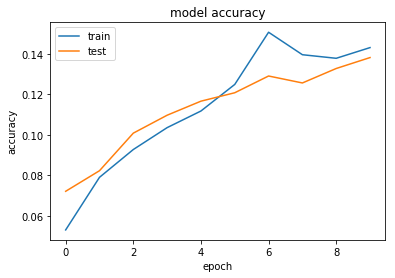

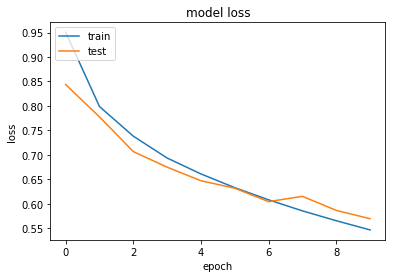

In [13]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()